In [ ]:
pip install wandb

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import wandb
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split


In [ ]:
wandb.login()

wandb: Currently logged in as: kiritgpillai (kiritgpillai-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Define a sweep configuration for hyperparameter tuning
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'batch_size': {'values': [32, 64, 128]},
        'optimizer': {'values': ['adam','adadelta', 'rmsprop']},
        'weight_decay': {'values': [0.0, 0.0001, 0.001]},
        'epochs': {'value': 50}

    }
}


# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="a100-resnet-hyperparameter-tuning")


Create sweep with ID: mjwr3ao0
Sweep URL: https://wandb.ai/kiritgpillai-new-york-university/a100-resnet-hyperparameter-tuning/sweeps/mjwr3ao0


In [ ]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes for training (80%) and testing (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for the training and testing subsets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified


In [ ]:
# Residual Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1, use_1x1=False):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        # Use a 1x1 conv for the second layer if specified
        ksize = 1 if use_1x1 else 3
        pad   = 0 if use_1x1 else 1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=ksize, padding=pad, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CustomResNet, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),  
            nn.BatchNorm2d(16),                                               
            nn.Conv2d(16, 64, kernel_size=3, padding=1, bias=False),         
            nn.BatchNorm2d(64),                                               
            nn.Dropout(0.1)                                                   
        )
        self.init_custom = Block(64, 64, dropout_rate=0.1, use_1x1=True)       
        self.blocks64 = nn.Sequential(*[Block(64, 64, dropout_rate=0.1) for _ in range(2)])
        self.trans128 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(128),                                                 
            nn.Dropout(0.1)                                                      
        )
        self.custom128 = Block(128, 128, dropout_rate=0.1, use_1x1=True)         
        self.blocks128 = nn.Sequential(*[Block(128, 128, dropout_rate=0.1) for _ in range(4)])
        self.trans256 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(256),                                                 
            nn.Dropout(0.1)                                                       
        )
        self.custom256 = Block(256, 256, dropout_rate=0.1, use_1x1=True)        
        self.blocks256 = nn.Sequential(*[Block(256, 256, dropout_rate=0.1) for _ in range(2)])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.initial(x)           
        x = self.init_custom(x)        
        x = self.blocks64(x)          
        x = self.trans128(x)           
        x = self.custom128(x)          
        x = self.blocks128(x)          
        x = self.trans256(x)          
        x = self.custom256(x)         
        x = self.blocks256(x)         
        x = self.pool(x)               
        x = torch.flatten(x, 1)
        x = self.fc(x)                
        return x


In [ ]:
# Instantiate the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet(num_classes=10).to(device)

# Print the summary
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 64, 32, 32]           9,216
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           4,096
      BatchNorm2d-10           [-1, 64, 32, 32]             128
            Block-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
          Dropout-14           [-1, 64,

In [ ]:
model = CustomResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train the model using wandb hyperparameters
def train_sweep():
    with wandb.init() as run:
        config = wandb.config
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)

        # Training loop
        for epoch in range(config.epochs):
            epoch_start = time.time()
            model.train()
            running_loss = 0.0
            train_correct = 0
            train_total = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (preds == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * train_correct / train_total

            # Log results
            wandb.log({"train_loss": train_loss, "train_acc": train_acc, "epoch": epoch+1})

wandb.agent(sweep_id, train_sweep, count=10) 

wandb: Agent Starting Run: qjucqsug with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0001


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_acc,97.644
train_loss,0.06903


wandb: Agent Starting Run: qx2jiokr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▆▇▇▇█▇█▇▇▇▇▇█▇█▇▇███▇███▇▇█▇██▇█▇█▇█
train_loss,█▅▃▃▃▂▂▂▂▂▁▁▂▂▂▂▁▂▁▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,50
train_acc,99.284
train_loss,0.02272


wandb: Agent Starting Run: 70s11drz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0001


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▂▃▄▄▅▄▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
train_loss,█▇▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,50
train_acc,96.57
train_loss,0.10073


wandb: Agent Starting Run: czk1ti9w with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▄▄▅▇▆▅▅▇▇▆▆▆▇▆▆▇▇▆▇▇▇▇▇▇▆▇█▇█▇▇▇▇██▇█
train_loss,█▅▄▅▄▄▂▃▄▄▂▂▂▃▃▃▃▂▂▁▂▂▂▂▁▂▂▂▁▁▂▁▂▂▂▁▁▁▁▁
epoch,50
train_acc,99.568
train_loss,0.01184


wandb: Agent Starting Run: p145z6hk with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0001


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▄▇▆▅▇▆▇▇█▆▇█▄▆█▆▇▅▆▇▇▆▆▅▆▇▅▄▅▅▃▅▅▅▅▃▄▃
train_loss,█▄▃▂▂▃▁▁▂▂▁▁▂▂▂▁▃▂▃▃▃▄▄▃▄▄▅▅▃▅▇▅▅▆▅▇▅▆▇▇
epoch,50
train_acc,99.606
train_loss,0.01333


wandb: Agent Starting Run: 2wmqycof with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▂▃▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇████
train_loss,█▇▆▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch,50
train_acc,99.282
train_loss,0.02219


wandb: Agent Starting Run: 6gfhfspw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▂▂▂▃▃▄▃▄▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▆▇▇▇█▇▇██▇███▇
train_loss,█▇▇▇▆▆▆▆▅▅▆▅▄▄▅▃▄▃▄▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▁▂
epoch,50
train_acc,99.256
train_loss,0.02135


wandb: Agent Starting Run: k4gi5yzr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.001


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,▁▆▇███████████▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,50
train_acc,85.312
train_loss,0.42886


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3bp2u87s with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.001


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▃▂▄▃▄▄▅▅▅▄▆▅▃▆▅▆▇▅▆▇▇█▆▆▇▆▇▆▅▆▆▅▅▅▆▇▅▆
train_loss,█▆▅▅▃▄▄▃▃▅▄▂▃▄▂▃▂▁▂▂▂▁▁▂▂▁▁▂▂▁▂▂▂▁▂▁▁▂▂▁
epoch,50
train_acc,88.704
train_loss,0.33037


wandb: Agent Starting Run: 0mxguijw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.001


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
train_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_acc,98.014
train_loss,0.06152


In [ ]:
api = wandb.Api()
sweep = api.sweep('kiritgpillai-new-york-university/a100-resnet-hyperparameter-tuning/sweeps/mjwr3ao0')
runs = sweep.runs


# Sort runs by a specific metric (e.g., 'validation_accuracy')
sorted_runs = sorted(runs, key=lambda run: run.summary.get('validation_accuracy', 0), reverse=True)

# Extract the best run's hyperparameters
best_run = sorted_runs[0]
best_hyperparameters = best_run.config
print(f"Best Hyperparameters: {best_hyperparameters}")


Best Hyperparameters: {'epochs': 50, 'optimizer': 'adadelta', 'batch_size': 128, 'weight_decay': 0.001, 'learning_rate': 0.0001}


In [ ]:
# Set hyperparameters
num_epochs = 300
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 64

# Initialize loss function
criterion = nn.CrossEntropyLoss()


# Initialize the Adadelta optimizer
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [ ]:
# Initialize variables to track the best validation accuracy and corresponding epoch
best_val_acc = 0.0
best_epoch = 0

# Training loop
for epoch in range(num_epochs):
    epoch_start = time.time()

    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = 100 * correct / total

    # Check if the current model has the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        # Save the model's state_dict
        torch.save(model.state_dict(), 'best_model.pth')

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%\n")

print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}.")

Epoch 1/300 completed in 13.08s
Train Loss: 1.3823, Train Acc: 49.40%
Validation Loss: 1.7236, Validation Acc: 39.60%

Epoch 2/300 completed in 13.47s
Train Loss: 1.3750, Train Acc: 49.90%
Validation Loss: 1.6936, Validation Acc: 40.38%

Epoch 3/300 completed in 12.58s
Train Loss: 1.3702, Train Acc: 49.84%
Validation Loss: 1.7088, Validation Acc: 40.16%

Epoch 4/300 completed in 13.29s
Train Loss: 1.3661, Train Acc: 50.06%
Validation Loss: 1.7074, Validation Acc: 40.18%

Epoch 5/300 completed in 12.76s
Train Loss: 1.3645, Train Acc: 50.16%
Validation Loss: 1.6962, Validation Acc: 40.64%

Epoch 6/300 completed in 13.28s
Train Loss: 1.3614, Train Acc: 50.41%
Validation Loss: 1.6821, Validation Acc: 40.88%

Epoch 7/300 completed in 12.84s
Train Loss: 1.3530, Train Acc: 50.45%
Validation Loss: 1.6768, Validation Acc: 41.06%

Epoch 8/300 completed in 12.53s
Train Loss: 1.3538, Train Acc: 50.74%
Validation Loss: 1.6856, Validation Acc: 41.04%

Epoch 9/300 completed in 13.56s
Train Loss: 1.34

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7868d048a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7868d048a7a0>  
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
     ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^  ^ 
^  File "/us

Epoch 156/300 completed in 13.48s
Train Loss: 1.0375, Train Acc: 63.02%
Validation Loss: 1.2442, Validation Acc: 56.70%

Epoch 157/300 completed in 14.25s
Train Loss: 1.0336, Train Acc: 63.09%
Validation Loss: 1.2302, Validation Acc: 57.13%

Epoch 158/300 completed in 13.08s
Train Loss: 1.0342, Train Acc: 63.20%
Validation Loss: 1.2469, Validation Acc: 56.66%

Epoch 159/300 completed in 13.53s
Train Loss: 1.0299, Train Acc: 62.88%
Validation Loss: 1.2368, Validation Acc: 57.18%

Epoch 160/300 completed in 12.66s
Train Loss: 1.0284, Train Acc: 63.22%
Validation Loss: 1.2397, Validation Acc: 56.90%

Epoch 161/300 completed in 13.23s
Train Loss: 1.0318, Train Acc: 63.18%
Validation Loss: 1.2207, Validation Acc: 57.48%

Epoch 162/300 completed in 13.77s
Train Loss: 1.0281, Train Acc: 63.35%
Validation Loss: 1.2071, Validation Acc: 57.95%

Epoch 163/300 completed in 12.72s
Train Loss: 1.0270, Train Acc: 63.44%
Validation Loss: 1.2295, Validation Acc: 57.47%

Epoch 164/300 completed in 12.91

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'ResNet_300epoch_70.pt')
print("Model saved to ResNetmodel.pt")


Model saved to ResNetmodel.pt


<ipython-input-93-4cbbf6d5690d>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


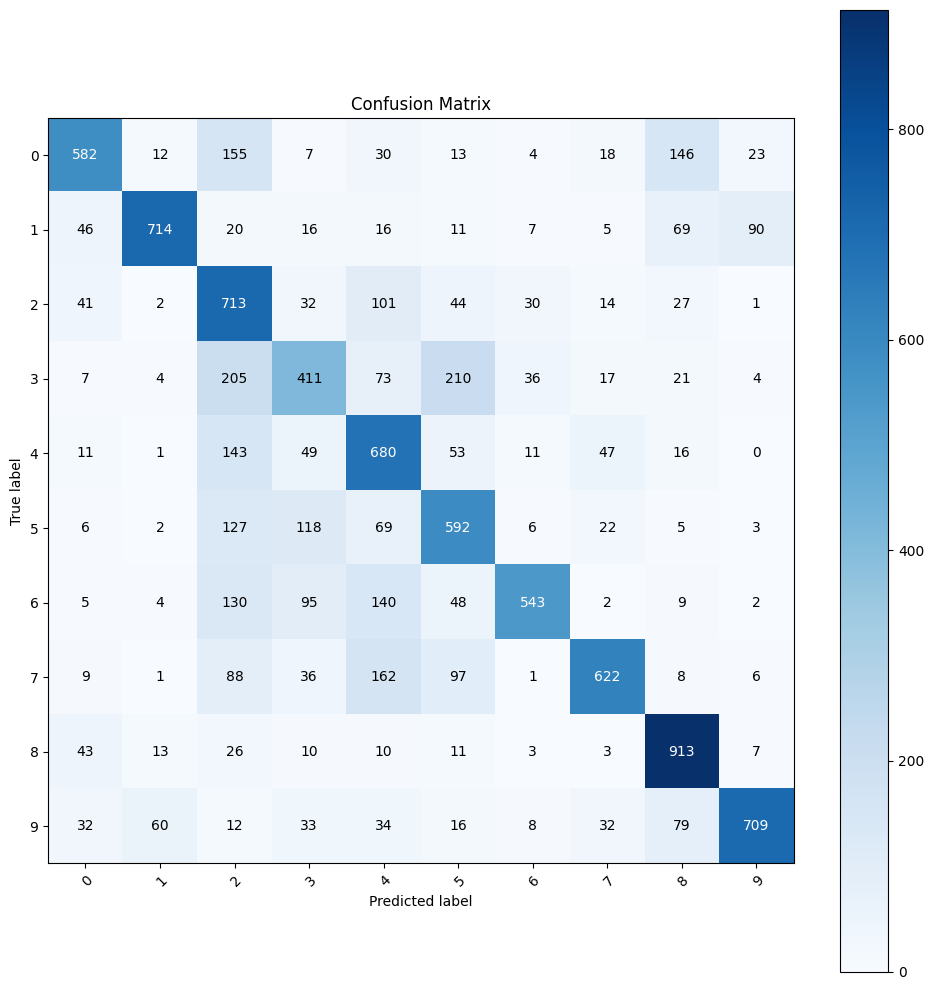

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the test data to make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

classes = list(range(10))  #  10 classes (CIFAR-10)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [ ]:
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss()


with open('cifar_test_nolabel.pkl', 'rb') as f:
    test_data = pickle.load(f, encoding='latin1')

print("Loaded test data keys:", list(test_data.keys()))

data = test_data[b'data']
ids = test_data[b'ids']

print("Data shape before processing:", data.shape)
print("IDs shape:", ids.shape)

if data.ndim == 4 and data.shape[-1] == 3:
    data = np.transpose(data, (0, 3, 1, 2))
print("Data shape after transposition:", data.shape)


data_tensor = torch.tensor(data, dtype=torch.float32)

data_tensor = data_tensor / 255.0

test_dataset = TensorDataset(data_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in testloader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend(preds.cpu().numpy())

results = list(zip(ids, predictions))

<ipython-input-89-28ca7a4d8f76>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


Loaded test data keys: [b'data', b'ids']
Data shape before processing: (10000, 32, 32, 3)
IDs shape: (10000,)
Data shape after transposition: (10000, 3, 32, 32)


In [ ]:
# Pair sample IDs with predictions and export to CSV
results = list(zip(ids, predictions))
print("Sample results (ID, Labels):")
for r in results[:10]:
    print(r)

df = pd.DataFrame(results, columns=['ID', 'Labels'])
df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Sample results (ID, Labels):
(0, 2)
(1, 2)
(2, 8)
(3, 2)
(4, 4)
(5, 2)
(6, 8)
(7, 2)
(8, 8)
(9, 0)
Predictions saved to predictions.csv
